In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/workspaces/secure_inference/')
from research.distortion.parameters.classification.resent.resnet18_8xb16_cifar100 import Params as resnet18_8xb16_cifar100_Params

In [3]:
layer_names = resnet18_8xb16_cifar100_Params().LAYER_NAMES
stats = {l: np.load(f'/workspaces/secure_inference/tests/12_11_multi_channel/all_stats/{l}.npy') for l in layer_names}

In [46]:
'layer3_1_2' in layer_names

True

In [52]:
print(sum([a[0].size for a in stats.values()]))
print(sum([v[0].size for k, v in stats.items() if k in ["layer2_0_1", "layer3_0_1", "layer4_0_1", "layer3_1_2"]]))
print(sum([v[0].size for k, v in stats.items() if k in ["layer2_0_1", "layer3_0_1", "layer4_0_1"]]))

557056
73728
57344


In [4]:
cur_layer = stats['layer4_0_1']
not_zero = cur_layer.any(axis=(0, 2, 3)).nonzero()
cur_layer = cur_layer[:, not_zero[0]]

shape = cur_layer.shape
flat = cur_layer.reshape(shape[0], shape[1], -1)
hamming_distances = np.sum(flat[:, None] != flat[:, :, None], axis=0) / shape[0]  # Shape (d2, d2, d3 * d4)
print(hamming_distances.shape)
hamming_distances = hamming_distances.reshape(shape[1], shape[1], shape[2], shape[3])
hamming_distances.shape

(443, 443, 16)


(443, 443, 4, 4)

In [78]:
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, KMeans

In [49]:
channel_distances = np.quantile(hamming_distances, 0.3, axis=(2, 3))
plt.hist(channel_distances, bins=100)
plt.show()

In [77]:
data = cur_layer.transpose(1, 0, 2, 3)
data = data.reshape(data.shape[0], -1).astype(np.float32)
data

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [79]:
clusters3 = KMeans(n_clusters=40).fit(data)

In [82]:
np.unique(clusters3.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39], dtype=int32),
 array([ 2,  7,  4,  5,  4,  9,  2, 25, 23, 38,  3,  9,  3,  9,  2,  7,  9,
         1, 26, 21, 11,  1, 47,  1, 22,  1,  2,  1,  1,  1,  1, 51,  3,  1,
         1, 78,  2,  1,  4,  4]))

In [54]:
# channels_distance = hamming_distances.mean(axis=(2, 3))
clusters = AffinityPropagation(affinity='precomputed').fit(-channel_distances)

In [68]:
clusters2 = AgglomerativeClustering(n_clusters=40, affinity='precomputed', linkage='complete').fit_predict(-channel_distances)

In [83]:
np.unique(clusters3.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39], dtype=int32),
 array([ 2,  7,  4,  5,  4,  9,  2, 25, 23, 38,  3,  9,  3,  9,  2,  7,  9,
         1, 26, 21, 11,  1, 47,  1, 22,  1,  2,  1,  1,  1,  1, 51,  3,  1,
         1, 78,  2,  1,  4,  4]))

(38,)
(38, 38)
0.1983240185682133


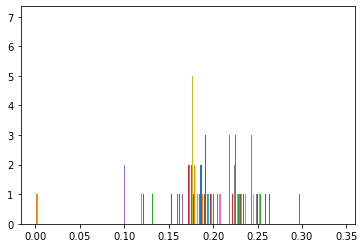

In [120]:
cur_label = np.nonzero(clusters3.labels_ == 9)[0]
print(cur_label.shape)
print(channel_distances[np.ix_(cur_label, cur_label)].shape)
print(channel_distances[np.ix_(cur_label, cur_label)].mean())
plt.hist(channel_distances[np.ix_(cur_label, cur_label)], bins=100)
plt.show()


In [137]:
from sklearn.metrics import pairwise_distances
samples = cur_layer[:, cur_label].transpose(1, 2, 3, 0)
samples_original_shape = samples.shape
# samples = cur_layer.transpose(1, 2, 3, 0)
samples = samples.reshape(-1, samples.shape[-1])
affinity_mat = -pairwise_distances(samples, metric='hamming')

In [178]:
i = np.nonzero(pixel_clusters.labels_ == 55)[0]
affinity_mat[np.ix_(i, i)].mean()

-0.21878884992493902

In [176]:
19 / 25

0.76

In [138]:
pixel_clusters = AffinityPropagation(affinity='precomputed', preference=np.quantile(affinity_mat, 0.7)).fit(affinity_mat)

In [168]:
np.unique(pixel_clusters.labels_, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120]),
 array([  1,   1,   1,   1, 237,   1,   1, 164,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,
          1,   1,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   4,
          1,   1,   1

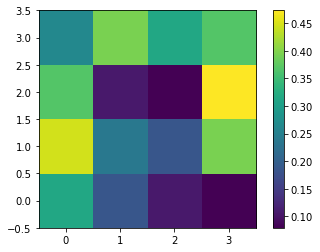

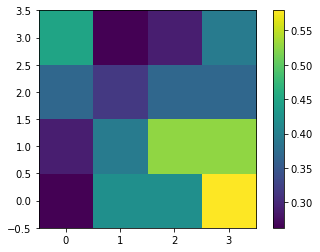

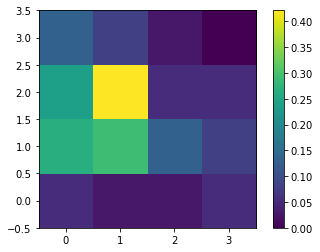

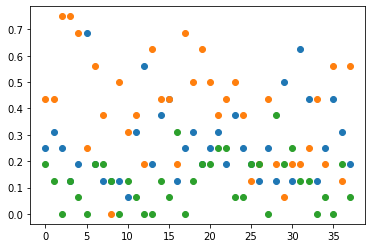

In [170]:

example1 = pixel_clusters.labels_.reshape(samples_original_shape[:-1]) == 7
example2 = pixel_clusters.labels_.reshape(samples_original_shape[:-1]) == 4
example3 = pixel_clusters.labels_.reshape(samples_original_shape[:-1]) == 55
plt.imshow(example1.mean(axis=0), origin='lower')
plt.colorbar()
plt.show()
plt.imshow(example2.mean(axis=0), origin='lower')
plt.colorbar()
plt.show()
plt.imshow(example3.mean(axis=0), origin='lower')
plt.colorbar()
plt.show()
plt.scatter(np.arange(example1.shape[0]), example1.mean(axis=(1, 2)), label=1)
plt.scatter(np.arange(example2.shape[0]), example2.mean(axis=(1, 2)), label=2)
plt.scatter(np.arange(example3.shape[0]), example3.mean(axis=(1, 2)), label=3)
plt.show()


In [167]:
print(samples[np.nonzero(pixel_clusters.labels_ == 7)].mean())
print(samples[np.nonzero(pixel_clusters.labels_ == 4)].mean())
print(samples.mean())
print(cur_layer.mean())

0.11113162157012195
0.12272135416666667
0.14926308079769737
0.15491011987690462


array([0.25  , 0.3125, 0.25  , 0.125 , 0.1875, 0.6875, 0.1875, 0.125 ,
       0.125 , 0.125 , 0.0625, 0.3125, 0.5625, 0.1875, 0.375 , 0.4375,
       0.125 , 0.25  , 0.3125, 0.1875, 0.25  , 0.3125, 0.1875, 0.375 ,
       0.25  , 0.1875, 0.125 , 0.25  , 0.125 , 0.5   , 0.125 , 0.625 ,
       0.4375, 0.125 , 0.25  , 0.4375, 0.3125, 0.1875])

In [139]:
np.unique(pixel_clusters.labels_, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120]),
 array([  1,   1,   1,   1, 237,   1,   1, 164,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,
          1,   1,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   4,
          1,   1,   1

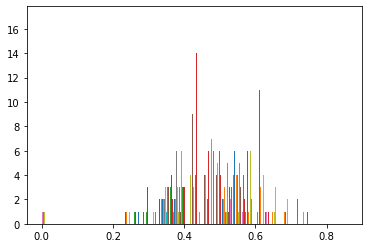

In [29]:
a = hamming_distances.mean(axis=(2, 3))
plt.hist(hamming_distances.mean(axis=(2, 3)), bins=100)
plt.show()

In [6]:
a = np.zeros([10, 5, 2, 2])
b = np.zeros([10, 5, 2, 2])
c = a[:, None] != b[:, :, None]
c.shape

(10, 5, 5, 2, 2)